In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = None,
    mask = False))

see one see two 2 2


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8580246913580247, Loss: 0.5576370027330186
Checkpoint 200, Accuracy: 0.8641975308641975, Loss: 0.5703483157687717
Checkpoint 300, Accuracy: 0.8518518518518519, Loss: 0.5620176174022533
Checkpoint 400, Accuracy: 0.8580246913580247, Loss: 0.5679090287950304
Checkpoint 500, Accuracy: 0.8580246913580247, Loss: 0.5642931549637406


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

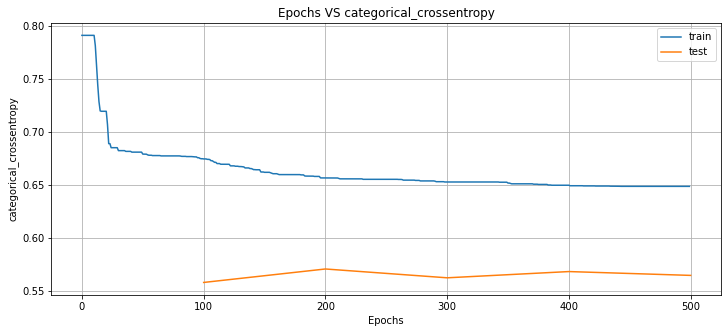

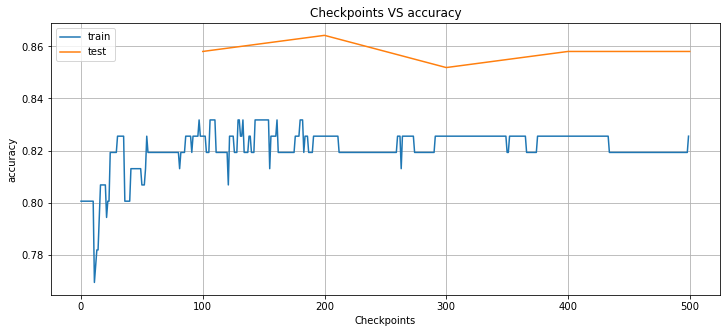

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [[0.12896276]
 [0.5298667 ]
 [0.34117055]]
[0. 0. 1.] <-> [[0.02256489]
 [0.54708326]
 [0.43035185]]
[1. 0. 0.] <-> [[0.33261085]
 [0.38596594]
 [0.28142327]]
[1. 0. 0.] <-> [[0.49722838]
 [0.2895452 ]
 [0.21322644]]
[1. 0. 0.] <-> [[0.34093377]
 [0.38065317]
 [0.27841306]]
[1. 0. 0.] <-> [[0.9031009 ]
 [0.07009014]
 [0.02680902]]
[1. 0. 0.] <-> [[0.89636207]
 [0.07166573]
 [0.03197217]]
[0. 0. 1.] <-> [[0.03319687]
 [0.57590675]
 [0.3908964 ]]
[1. 0. 0.] <-> [[0.6322165 ]
 [0.22219698]
 [0.14558643]]
[1. 0. 0.] <-> [[0.49670887]
 [0.28981355]
 [0.21347754]]
[1. 0. 0.] <-> [[0.8621488 ]
 [0.09242044]
 [0.04543077]]
[1. 0. 0.] <-> [[0.5322376 ]
 [0.27214026]
 [0.19562218]]
[0. 1. 0.] <-> [[0.85462224]
 [0.09699408]
 [0.04838357]]
[1. 0. 0.] <-> [[0.5657089 ]
 [0.25587896]
 [0.17841224]]
[1. 0. 0.] <-> [[0.5427728 ]
 [0.26704967]
 [0.1901775 ]]
[0. 0. 1.] <-> [[0.90140903]
 [0.06952402]
 [0.02906698]]
[0. 0. 1.] <-> [[0.000959  ]
 [0.04537783]
 [0.9536632 ]]
[1. 0. 0.] <->

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8580246913580247, 'mean_square_error': 2.885672824834213, 'categorical_crossentropy': 0.5576370027330186, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 13, 'tn_hit': 15, 'fn_hit': 4}, 1: {'tp_hit': 2, 'fp_hit': 6, 'tn_hit': 87, 'fn_hit': 13}, 2: {'tp_hit': 7, 'fp_hit': 4, 'tn_hit': 91, 'fn_hit': 6}}, 'checkpoint': 100} 


{'accuracy': 0.8641975308641975, 'mean_square_error': 2.893156605225902, 'categorical_crossentropy': 0.5703483157687717, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 14, 'tn_hit': 14, 'fn_hit': 3}, 1: {'tp_hit': 5, 'fp_hit': 8, 'tn_hit': 85, 'fn_hit': 10}, 2: {'tp_hit': 4, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 9}}, 'checkpoint': 200} 


{'accuracy': 0.8518518518518519, 'mean_square_error': 2.9284352492829933, 'categorical_crossentropy': 0.5620176174022533, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 14, 'tn_hit': 14, 'fn_hit': 4}, 1: {'tp_hit': 5, 'fp_hit': 10, 'tn_hit': 83, 'fn_hit': 10}, 2: {'tp_hit': 3, 'fp_hit': 0, 'tn_hit': 95, 'fn_hi

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[ 2.1140282 ]
 [ 0.58777714]
 [ 0.9495943 ]
 [-2.253166  ]
 [ 0.02456007]]
 bias: [-3.]

Neuron 1: weights:
[[1.4554871 ]
 [2.7645667 ]
 [3.        ]
 [1.1129092 ]
 [0.58730954]]
 bias: [2.1899781]

Neuron 2: weights:
[[-0.27812725]
 [ 0.94227505]
 [-2.0886137 ]
 [ 1.8198246 ]
 [ 0.06717477]]
 bias: [-2.1561663]

Neuron 3: weights:
[[ 1.2321011]
 [-1.2988864]
 [-0.3594231]
 [-1.6800835]
 [ 2.7353284]]
 bias: [-3.]

$
Layer 2
Neuron 0: weights:
[[-2.9282105 ]
 [-1.0981568 ]
 [ 0.30055347]
 [-2.8527408 ]]
 bias: [0.68025714]

Neuron 1: weights:
[[ 1.9068319]
 [ 0.620241 ]
 [-2.2386076]
 [-0.7028817]]
 bias: [-1.8138223]

Neuron 2: weights:
[[-0.02145064]
 [ 0.99858475]
 [ 0.6717076 ]
 [ 2.89435   ]]
 bias: [-2.9176512]

$

